In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 

In [2]:
#구 이름 전부 적어놓기
gooList = '강서구 금정구 기장군 남구 동구 동래구 부산진구 북구 사상구 사하구 서구 수영구 연제구 영도구 중구 해운대구'.split()



In [3]:
#data prepartion
def sdf(name):
    df = pd.read_csv(name+'.csv')
    df.insert(2, "gooName", name, True)
    return df
init_df = pd.read_csv('강서구.csv')
init_df.insert(2, "gooName", '강서구', True)

#모든 구 하나로 묶기
for k in gooList[1:]:
    init_df = pd.concat([init_df,sdf(k)], ignore_index=True)
df = init_df
df.sample(frac=0.1, replace=True).head()

#결측치 제거
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
replaceDic ={'총강수량(mm)': 'total_rain','강수계속시간(시간)':'rain_duration','최다강수1H':'max_rain',
                   '일강수량(mm)':'daily_rain','누적 강수량(mm)-2일':'culmu_rain_2','누적 강수량(mm)-3일':'culmu_rain_3',
                   '최대풍속(m/s)':'max_wind','평균기온(℃)':'avg_temp','기간(일)':'duration' ,'침수면적(1,000㎡)':'sunk','태풍':'typhoon','피해액(백만원)':'damage'}
df = df.rename(columns = replaceDic)

In [5]:
#one_hot_encoding gooName
onehotGoo = pd.get_dummies(df['gooName'],dtype = int)
#onehotGoo.sample(frac=0.1, replace=True).head()

#one_hot_encoding gooName
onehotTyphoon= pd.get_dummies(df['typhoon'],dtype = int)
#onehotTyphoon.sample(frac=0.1, replace=True).head()


my_land =onehotGoo.columns.values.tolist()
my_typhoon = onehotTyphoon.columns.values.tolist()
df[my_land] = onehotGoo
df[my_typhoon] = onehotTyphoon
#df.sample(frac=0.1, replace=True).head()

In [6]:
#classifying damage
df['damage'] =df['damage'].apply(lambda x:float(str(x).replace(",","")))
def classify(num):
    if(num > 600000):
        return 4
    if(100000< num < 500000):
        return 3
    if(50000 < num < 100000):
        return 2
    if(10000 < num < 50000):
        return 1
    return 0
df['damage'] =df['damage'].apply(classify )

In [7]:
usableNumerical = ['damage','total_rain','duration']
usableOnehot = my_land+my_typhoon


In [8]:
X = df[usableNumerical[1:]+usableOnehot].values
y = df['damage'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)
print(X_train.shape); print(X_test.shape)

(719, 27)
(180, 27)


In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

count_classes = y_test.shape[1]
print(count_classes)

5


In [10]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=27))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
model.fit(X_train, y_train, epochs=300)

Epoch 1/300
23/23 [==============================] - 1s 4ms/step - loss: 10.2772 - accuracy: 0.2462
Epoch 2/300
23/23 [==============================] - 0s 3ms/step - loss: 2.4049 - accuracy: 0.3241
Epoch 3/300
23/23 [==============================] - 0s 3ms/step - loss: 1.6007 - accuracy: 0.3074
Epoch 4/300
23/23 [==============================] - 0s 3ms/step - loss: 1.5034 - accuracy: 0.3783
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 1.5109 - accuracy: 0.3561
Epoch 6/300
23/23 [==============================] - 0s 3ms/step - loss: 1.4964 - accuracy: 0.3908
Epoch 7/300
23/23 [==============================] - 0s 4ms/step - loss: 1.5077 - accuracy: 0.3602
Epoch 8/300
23/23 [==============================] - 0s 3ms/step - loss: 1.5237 - accuracy: 0.3477
Epoch 9/300
23/23 [==============================] - 0s 3ms/step - loss: 1.5153 - accuracy: 0.3839
Epoch 10/300
23/23 [==============================] - 0s 3ms/step - loss: 1.4921 - accuracy: 0.3936
Epoch 11

In [12]:

pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

23/23 [==============================] - 0s 3ms/step
Accuracy on training data: 0.8414464592933655% 
 Error on training data: 0.15855354070663452
6/6 [==============================] - 0s 3ms/step
Accuracy on test data: 0.800000011920929% 
 Error on test data: 0.19999998807907104


In [14]:
#3~18
goodic = {}
import numpy as np
import random
def run(rowIdx):
    global goodic

    original = df.loc[rowIdx:rowIdx][usableNumerical[1:]+usableOnehot].values
    #print(original)
    try:
        originIdx= np.where(original[0][2:18]==1)[0]
    except IndexError:
        print(original ,rowIdx)
        return 0

    for k in range(0,16):
        #print(original)
        real_test= model.predict(original)
        gooName = gooList[k]
        predVal =list(real_test[0]).index(max(real_test[0]))
        if(k == originIdx):
            #print("original",gooName,"is",predVal)
            try:
                goodic[gooName] += predVal
            except KeyError:
                goodic[gooName] = predVal
        else:
            #print(k,"is predicting",gooName,"is",predVal)
            try:
                goodic[gooName] += predVal
            except KeyError:
                goodic[gooName] = predVal
        original[0][k+2] = 0
        original[0][k+3] = 1

for i in range(100):
    run(random.randrange(1,800))

print( )

1/1 [==============================] - 0s 52ms/step



In [15]:
goodic

{'강서구': 195,
 '금정구': 143,
 '기장군': 265,
 '남구': 140,
 '동구': 123,
 '동래구': 47,
 '부산진구': 271,
 '북구': 271,
 '사상구': 165,
 '사하구': 71,
 '서구': 167,
 '수영구': 288,
 '연제구': 146,
 '영도구': 200,
 '중구': 20,
 '해운대구': 211}

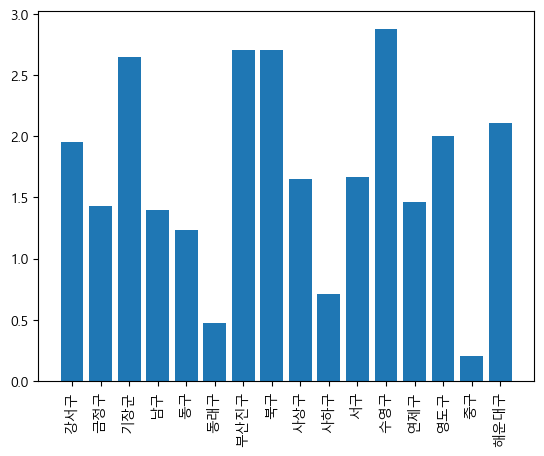

In [17]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가
font_path = "C:/Windows/Fonts/malgun.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

names = list(goodic.keys())
values = list(map(lambda x:x/100,goodic.values()))

plt.bar(range(len(goodic)), values, tick_label=names)
plt.xticks(rotation='vertical')
plt.show()

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1792      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 4485 (17.52 KB)
Trainable params: 4485 (17.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
df[usableNumerical].sample(frac=0.1, replace=True)

,damage,total_rain,duration
435,4,436.5,21.0
744,0,253.0,17.0
868,3,361.5,21.0
339,3,231.5,7.0
342,3,231.5,7.0
...,...,...,...
541,1,97.5,2.0
465,4,551.0,21.0
852,3,361.5,21.0
754,0,131.5,4.0


,번호,일자,gooName,sunk,damage,total_rain,duration,typhoon,rain_duration,max_rain,...,해운대구,고니,나비,뎬무,라마순,루사,매미,산바,없음,에위니아
0,1,1998-06-23,강서구,1.8,2,233.5,11.0,없음,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2,1998-06-24,강서구,1.8,2,233.5,11.0,없음,17.0,21.0,...,0,0,0,0,0,0,0,0,1,0
2,3,1998-06-25,강서구,1.8,2,233.5,11.0,없음,24.0,15.0,...,0,0,0,0,0,0,0,0,1,0
3,4,1998-06-26,강서구,1.8,2,233.5,11.0,없음,24.0,17.5,...,0,0,0,0,0,0,0,0,1,0
4,5,1998-06-27,강서구,1.8,2,233.5,11.0,없음,12.0,7.5,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,62,2009-07-15,해운대구,116.5,4,386.0,6.0,없음,24.0,33.5,...,1,0,0,0,0,0,0,0,1,0
895,63,2009-07-16,해운대구,116.5,4,386.0,6.0,없음,24.0,77.0,...,1,0,0,0,0,0,0,0,1,0
896,64,2012-07-14,해운대구,1.9,3,221.0,2.0,없음,22.0,16.5,...,1,0,0,0,0,0,0,0,1,0
897,65,2012-07-15,해운대구,1.9,3,221.0,2.0,없음,24.0,48.0,...,1,0,0,0,0,0,0,0,1,0
